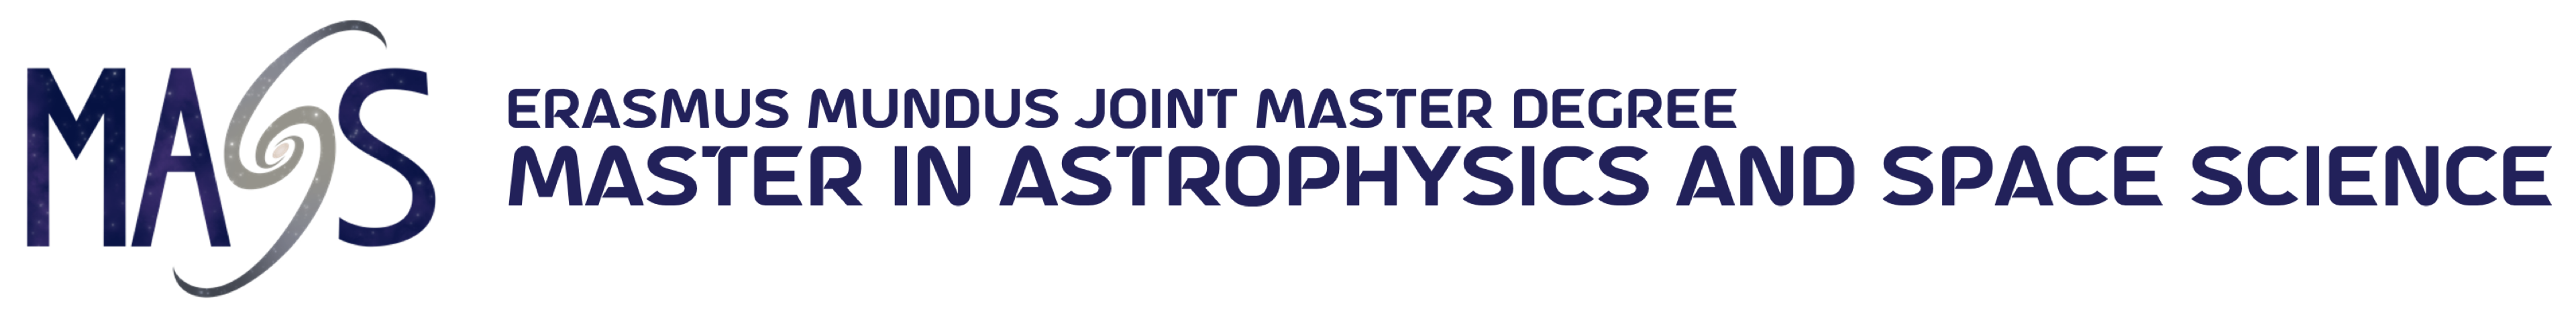
# AGNs Tutorial 2
## How to find a quasar

19 April 2024

**Student:** Francesca Borg

**Instructors:** Prof. Dragana Ilic, Natasa Pavlov

In [1]:
#importing the necessary packages
import numpy as np
import pandas as pd
import astropy.coordinates as coords
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import rcParams # for setting plot parameters in advance

# filters for different databases
from speclite import filters

#astroquery - for query search many data archives directly from Jupyter notebook
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

#other (might not be required)
from tabulate import tabulate
from astropy.table import Table

%matplotlib inline

GACS is operational after the datacentre migration but DataLink is not yet fully operational


# Part I. BPT Diagram

## Q. 1: Query
**Use SDSS DR18 SQL search to find all galaxies which:**
- **only narrow emission lines (FWHM < 500 km/s)**
- **high median SNR in g band (SNR > 40)**
- **fluxes of lines [OIII] 5007, H$\alpha$, H$\beta$ and [NII] 6583 larger than 5e-17 erg/s/cm^2**
- **fluxes are larger than errors in flux multiplied by 5 (to get good results)**

**Obtain the fluxes of the lines [OIII] 5007, H$\alpha$, H$\beta$ and [NII] 6583**

The FWHM is not a direct parameter in the SDSS database and must be calculated from $\sigma$. Following [1], FWHM is related to $\sigma$ through $\mathrm{FWHM}=\sigma\sqrt{8\ln{2}}=2.35482004503\sigma$. For the FWHM of the Balmer lines H$\alpha$ and H$\beta$, we use `sigma_balmer`, and for the FWHM of [OIII] 5007 and [NII] 6583, we use `sigma_forbidden`, which is the velocity dispersion measured simultaneously in all forbidden lines.

Note the fluxes (and errors in fluxes) of the lines are given in units of 1e-17 erg/s/cm^2.

In [2]:
sql_string=f"""SELECT s.specobjid, g.oiii_5007_flux, g.h_alpha_flux, g.h_beta_flux, g.nii_6584_flux, g.sigma_balmer*2.35482004503 AS H_FWHM, g.sigma_forbidden*2.35482004503 AS forbidden_FWHM, s.class, s.subclass

FROM
SpecObj AS s
JOIN
GalSpecLine AS g ON s.specobjid=g.specobjid
WHERE
(s.class = 'QSO' OR s.class = 'GALAXY')
AND g.sigma_balmer*2.35482004503 < 500
AND g.sigma_forbidden*2.35482004503 < 500
AND s.snmedian_g > 40
AND g.oiii_5007_flux > 5
AND g.oiii_5007_flux > g.oiii_5007_flux_err * 5
AND g.h_alpha_flux > 5
AND g.h_alpha_flux > g.h_alpha_flux_err * 5
AND g.h_beta_flux > 5
AND g.h_beta_flux > g.h_beta_flux_err * 5
AND g.nii_6584_flux > 5
AND g.nii_6584_flux > g.nii_6584_flux_err * 5"""

res = SDSS.query_sql(sql_string)

results = res.to_pandas()

In [3]:
results

,specobjid,oiii_5007_flux,h_alpha_flux,h_beta_flux,nii_6584_flux,H_FWHM,forbidden_FWHM,class,subclass
0,338924766721239040,78.39893,135.2715,45.66092,155.3322,478.1912,400.6823,GALAXY,BROADLINE
1,338991287174719488,324.13890,2299.2290,589.44490,1348.4960,275.2323,284.5573,GALAXY,STARFORMING
2,340022899698067456,638.90770,6541.7730,1519.60100,3709.2260,375.6672,376.6684,GALAXY,STARFORMING
3,389691963177199616,108.34530,168.1538,63.04348,242.2146,368.8275,319.7563,GALAXY,NaN
4,392955038911195136,44.03122,1010.6390,212.14120,412.7115,324.0439,331.7121,GALAXY,STARFORMING
...,...,...,...,...,...,...,...,...,...
969,3296707847290644480,18.52558,500.5771,130.78600,181.6212,114.3168,108.3346,GALAXY,STARFORMING
970,3302377479049603072,315.40850,988.5997,275.60200,328.0672,221.9163,213.3281,GALAXY,STARFORMING
971,3343996467592325120,80.73515,144.3445,39.16608,141.3919,268.7831,242.0867,GALAXY,BROADLINE
972,3344069859993479168,61.79113,530.8751,85.17157,311.0701,387.6888,382.9581,GALAXY,STARFORMING BROADLINE


## Q.2: BPT diagram

**For the obtained sample make the diagnostic BPT (Baldwin, Philips and Terlevich) diagram. This diagram determines the dominant ionization source for the objects: accretion disk (AGN) or hot emission stars (HII starburst region). For the BPT diagram, use the flux ratios of the lines [OIII]5007/H$\beta$ vs. [NII]6583/H$\alpha$.**

In [4]:
#assign ratios to plot
results['bpt_x'] = np.log10(results['nii_6584_flux']/results['h_alpha_flux'])
results['bpt_y'] = np.log10(results['oiii_5007_flux']/results['h_beta_flux'])
results

,specobjid,oiii_5007_flux,h_alpha_flux,h_beta_flux,nii_6584_flux,H_FWHM,forbidden_FWHM,class,subclass,bpt_x,bpt_y
0,338924766721239040,78.39893,135.2715,45.66092,155.3322,478.1912,400.6823,GALAXY,BROADLINE,0.060055,0.234765
1,338991287174719488,324.13890,2299.2290,589.44490,1348.4960,275.2323,284.5573,GALAXY,STARFORMING,-0.231733,-0.259712
2,340022899698067456,638.90770,6541.7730,1519.60100,3709.2260,375.6672,376.6684,GALAXY,STARFORMING,-0.246412,-0.376291
3,389691963177199616,108.34530,168.1538,63.04348,242.2146,368.8275,319.7563,GALAXY,NaN,0.158494,0.235170
4,392955038911195136,44.03122,1010.6390,212.14120,412.7115,324.0439,331.7121,GALAXY,STARFORMING,-0.388949,-0.682864
...,...,...,...,...,...,...,...,...,...,...,...
969,3296707847290644480,18.52558,500.5771,130.78600,181.6212,114.3168,108.3346,GALAXY,STARFORMING,-0.440304,-0.848789
970,3302377479049603072,315.40850,988.5997,275.60200,328.0672,221.9163,213.3281,GALAXY,STARFORMING,-0.479058,0.058591
971,3343996467592325120,80.73515,144.3445,39.16608,141.3919,268.7831,242.0867,GALAXY,BROADLINE,-0.008976,0.314153
972,3344069859993479168,61.79113,530.8751,85.17157,311.0701,387.6888,382.9581,GALAXY,STARFORMING BROADLINE,-0.232134,-0.139369


In [5]:
#setting plot parameters
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

(-1.5, 1.0)

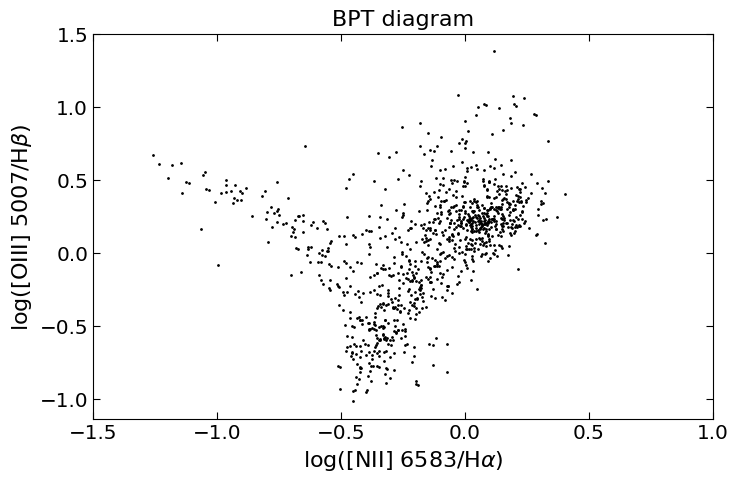

In [6]:
#plot BPT diagram
fig=plt.figure(figsize=(8, 5))
plt.tick_params(axis="both", direction='in', length=5, bottom=1, top=1, left=1, right=1, which='both')
plt.scatter(results['bpt_x'],results['bpt_y'], s=1, c='black')
plt.xlabel(r'log([NII] 6583/H$\alpha$)', fontsize = 16)
plt.ylabel(r'log([OIII] 5007/H$\beta$)', fontsize = 16)
plt.title('BPT diagram', fontsize = 16)
plt.xlim(-1.5,1)

According to Kewley et al. (2001), the extreme starburst classification line is described by (eq. 5)

$$\mathrm{log}(\dfrac{[OIII]\lambda 5007}{H\beta})=\dfrac{0.61}{\mathrm{log}([NII]/H\alpha)-0.47}+1.19$$



In [7]:
kew_x = np.linspace(-2,0.4,1000)
#avoid singularity at x=0.47
kew_y = 0.61/(kew_x-0.47)+1.19

According to Kaufmann et al. (2003), the classification line is given by (eq. 1)

$$\mathrm{log}(\dfrac{[OIII]\lambda 5007}{H\beta})=\dfrac{0.61}{\mathrm{log}([NII]/H\alpha)-0.05}+1.3$$

In [8]:
kauf_x = np.linspace(-2,0.04,1000)
#avoid singularity at x=0.05
kauf_y = 0.61/(kauf_x-0.05)+1.3

Additionally, following the classification in Fig. 1 from Kaufmann et al. (2003), note that Seyfert galaxies are often defined to have $[OIII]/H\beta>3$ and $[NII]/H\alpha>0.6$, whereas LINERs have $[OIII]/H\beta<3$ and $[NII]/H\alpha>0.6$.

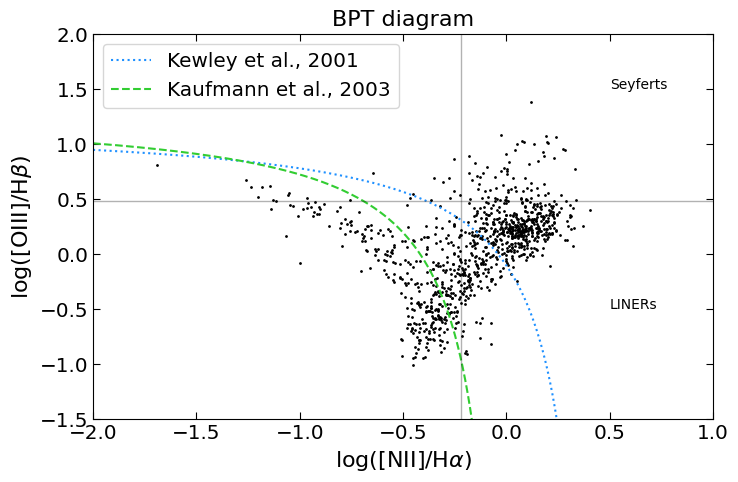

In [9]:
#plot BPT diagram
fig=plt.figure(figsize=(8, 5))
plt.tick_params(axis="both", direction='in', length=5, bottom=1, top=1, left=1, right=1, which='both')
plt.scatter(results['bpt_x'],results['bpt_y'], s=1, c='black')

#plot kewley line
plt.plot(kew_x,kew_y, color = 'dodgerblue', ls='dotted', label = 'Kewley et al., 2001')
#plot kaufmann line
plt.plot(kauf_x, kauf_y, color = 'limegreen', ls='--', label = 'Kaufmann et al., 2003')

#plot other lines according to Kaufmann (2003)
plt.axhline(np.log10(3), color='black', lw=1, alpha=0.3)
plt.axvline(np.log10(0.6), color='black', lw=1, alpha=0.3)
#label quadrants
plt.text(0.5,1.5,'Seyferts')
plt.text(0.5,-0.5,'LINERs')

#format plot
plt.xlabel(r'log([NII]/H$\alpha$)', fontsize = 16)
plt.ylabel(r'log([OIII]/H$\beta$)', fontsize = 16)
plt.title('BPT diagram', fontsize = 16)
plt.xlim(-2,1)
plt.ylim(-1.5,2)
plt.legend()

The BPT diagram can be used to classify the individual galaxies according to their dominant ionization source:
- accretion disk (AGN) if above the classification line
- hot emission stars (HII starburst region) if below the classification line

In [10]:
#add properties 'Kewley_class', 'Kaufmann_class'

#Kewley classification
kew_class = np.where( np.logical_or(results['bpt_y']> (0.61/(results['bpt_x']-0.47)+1.19), (results['bpt_x']>0)) , 'AGN', 'starburst')
results['kewley_class']=kew_class
#use logical OR to account for classification line singularity
shape = np.where( np.logical_or(results['bpt_y']> (0.61/(results['bpt_x']-0.47)+1.19), (results['bpt_x']>0)) , '8', '*')
results['shape']=shape

#Kaufmann classification
kauf_class = np.where( np.logical_or(results['bpt_y'] > (0.61/(results['bpt_x']-0.05)+1.3), results['bpt_x']>0), 'AGN', 'starburst')
#use logical OR to account for classification line singularity
results['kaufmann_class']=kauf_class
color = np.where( np.logical_or(results['bpt_y'] > (0.61/(results['bpt_x']-0.05)+1.3), results['bpt_x']>0), 'red', 'yellow')
results['color']=color

In [11]:
results

,specobjid,oiii_5007_flux,h_alpha_flux,h_beta_flux,nii_6584_flux,H_FWHM,forbidden_FWHM,class,subclass,bpt_x,bpt_y,kewley_class,shape,kaufmann_class,color
0,338924766721239040,78.39893,135.2715,45.66092,155.3322,478.1912,400.6823,GALAXY,BROADLINE,0.060055,0.234765,AGN,8,AGN,red
1,338991287174719488,324.13890,2299.2290,589.44490,1348.4960,275.2323,284.5573,GALAXY,STARFORMING,-0.231733,-0.259712,starburst,*,AGN,red
2,340022899698067456,638.90770,6541.7730,1519.60100,3709.2260,375.6672,376.6684,GALAXY,STARFORMING,-0.246412,-0.376291,starburst,*,AGN,red
3,389691963177199616,108.34530,168.1538,63.04348,242.2146,368.8275,319.7563,GALAXY,NaN,0.158494,0.235170,AGN,8,AGN,red
4,392955038911195136,44.03122,1010.6390,212.14120,412.7115,324.0439,331.7121,GALAXY,STARFORMING,-0.388949,-0.682864,starburst,*,starburst,yellow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,3296707847290644480,18.52558,500.5771,130.78600,181.6212,114.3168,108.3346,GALAXY,STARFORMING,-0.440304,-0.848789,starburst,*,starburst,yellow
970,3302377479049603072,315.40850,988.5997,275.60200,328.0672,221.9163,213.3281,GALAXY,STARFORMING,-0.479058,0.058591,starburst,*,starburst,yellow
971,3343996467592325120,80.73515,144.3445,39.16608,141.3919,268.7831,242.0867,GALAXY,BROADLINE,-0.008976,0.314153,AGN,8,AGN,red
972,3344069859993479168,61.79113,530.8751,85.17157,311.0701,387.6888,382.9581,GALAXY,STARFORMING BROADLINE,-0.232134,-0.139369,starburst,*,AGN,red


Text(-1.5, -1, 'Starburst')

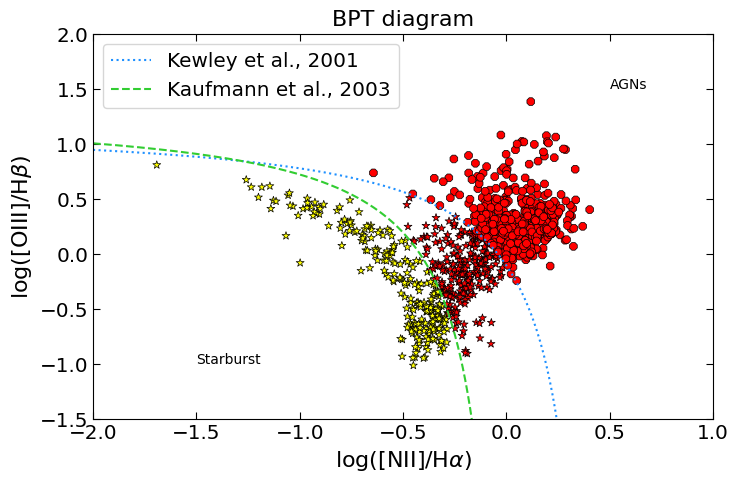

In [12]:
#plot BPT diagram
fig=plt.figure(figsize=(8, 5))
plt.tick_params(axis="both", direction='in', length=5, bottom=1, top=1, left=1, right=1, which='both')

for marker, d in results.groupby('shape'):
    plt.scatter(x=d['bpt_x'], y=d['bpt_y'], c=d['color'], marker=marker, edgecolors= "black", linewidth=0.5)

plt.xlabel(r'log([NII]/H$\alpha$)', fontsize = 16)
plt.ylabel(r'log([OIII]/H$\beta$)', fontsize = 16)
plt.title('BPT diagram', fontsize = 16)
plt.xlim(-2,1)
plt.ylim(-1.5,2)

#plot kewley line
plt.plot(kew_x,kew_y, color = 'dodgerblue', ls='dotted', label = 'Kewley et al., 2001')
#plot kaufmann line
plt.plot(kauf_x, kauf_y, color = 'limegreen', ls='--', label = 'Kaufmann et al., 2003')
plt.legend()

#label populations
plt.text(0.5,1.5,'AGNs')
plt.text(-1.5,-1,'Starburst')

# Part II. WISE color-color diagram

## Q.3: Cross-match with WISE

**For the sample of galaxies selected from SDSS database in Part I, find the corresponding WISE colors using WISE fluxes from Cross-identifications link: https://skyserver.sdss.org/dr14/en/help/docs/realquery.aspx#wisexmatch**

The colors we require are W1, W2, W3 in [mag].
Use the variables `w1mpro`, `w2mpro`, `w3mpro` from `WISE_allsky`, since they are the magnitudes measured with profile-fitting photometry for our objects with SNR > 40.

The new SQL query is:

```
SELECT
p.ra AS sdss_ra, p.dec AS sdss_dec, was.ra AS wise_ra, was.dec AS wise_dec,
p.psfmag_r AS r, was.w1mpro AS w1,
g.oiii_5007_flux, g.h_alpha_flux, g.h_beta_flux, g.nii_6584_flux, g.sigma_balmer*2.35482004503 AS H_FWHM, g.sigma_forbidden*2.35482004503 AS forbidden_FWHM,
s.class, s.subclass,
was.w1mpro, was.w2mpro, was.w3mpro

FROM wise_xmatch AS x
JOIN wise_allsky AS was ON x.wise_cntr = was.cntr
JOIN PhotoObjAll AS p ON x.sdss_objid = p.objID
JOIN SpecObjAll AS s ON s.specObjID = p.specObjID
JOIN GalSpecLine AS g ON s.specobjid=g.specobjid

WHERE
(s.class = 'QSO' OR s.class = 'GALAXY')
AND g.sigma_balmer*2.35482004503 < 500
AND g.sigma_forbidden*2.35482004503 < 500
AND s.snmedian_g > 40
AND g.oiii_5007_flux > 5
AND g.oiii_5007_flux > g.oiii_5007_flux_err * 5
AND g.h_alpha_flux > 5
AND g.h_alpha_flux > g.h_alpha_flux_err * 5
AND g.h_beta_flux > 5
AND g.h_beta_flux > g.h_beta_flux_err * 5
AND g.nii_6584_flux > 5
AND g.nii_6584_flux > g.nii_6584_flux_err * 5
AND p.nchild = 0
```

The query was submitted to the SDSS SQL search tool [4] and the results are saved in *Skyserver_SQL4_q3.csv*, which is loaded and read below.

In [13]:
results2 = pd.read_csv('Skyserver_SQL4_q3.csv', header=1)
results2

,sdss_ra,sdss_dec,wise_ra,wise_dec,r,w1,oiii_5007_flux,h_alpha_flux,h_beta_flux,nii_6584_flux,H_FWHM,forbidden_FWHM,class,subclass,w1mpro,w2mpro,w3mpro,wise_cntr,sdss_objid,specobjid
0,146.628757,34.916838,146.628833,34.917140,16.37781,11.940,173.52530,4204.3220,1019.06200,3133.5350,363.18690,321.2094,GALAXY,STARBURST,11.940,11.605,7.006,1461134801241017517,1237661382235783225,1794693572675528704
1,153.202376,43.145539,153.202393,43.145573,15.16157,10.633,141.22830,276.3123,88.41828,321.8531,134.49600,185.7727,GALAXY,BROADLINE,10.633,10.678,9.623,1537142401241035207,1237660635994259485,1371479997524502528
2,143.176249,2.533577,143.176263,2.533641,17.05236,12.691,47.88549,1360.4180,382.54200,860.1495,312.22960,275.6941,GALAXY,STARFORMING,12.691,12.462,8.452,1436103001241006144,1237654599949746289,640704979820111872
3,180.329534,56.570169,180.329622,56.570240,16.45819,11.699,71.68056,116.4147,22.47028,153.5428,343.64740,380.6946,GALAXY,BROADLINE,11.699,11.701,9.386,1813156001241039765,1237657610729357488,1479510319209408512
4,174.728890,3.580878,174.728897,3.580922,16.37154,11.642,107.56460,3212.7550,702.71580,1216.7800,134.38010,144.9825,GALAXY,STARFORMING,11.642,11.592,7.988,1754103001241033794,1237654031403712563,577752436958062592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,242.398705,8.956686,242.398840,8.956539,16.48749,11.549,80.75883,138.7333,28.08064,135.7143,68.88296,180.8282,GALAXY,BROADLINE,11.549,11.624,9.817,2420109001241019730,1237662637987069988,2844058975685601280
957,126.575168,27.840223,126.575298,27.840127,15.66866,10.936,201.57480,662.5453,206.01010,450.8914,443.05810,378.6714,GALAXY,AGN BROADLINE,10.936,10.969,9.759,1267127201241035915,1237660764836135043,1426645798166226944
958,38.197620,0.678089,38.197665,0.678057,17.10240,13.864,5639.00600,4075.1110,1402.15100,237.3731,120.51260,113.4413,GALAXY,STARBURST,13.864,13.760,10.516,378100001241034281,1237657587096813624,458390276445071360
959,196.914220,6.335939,196.914298,6.335928,16.02470,11.220,101.11320,750.1812,178.31770,444.3834,296.06020,283.5113,GALAXY,STARFORMING,11.220,11.143,7.850,1974106001241023443,1237661974404923406,2021061876653254656


## Q.4
**Assign classes (AGN & (u)LIRGS, spheroids, intermediate disks and SF disks) to the sample using the thresholds from the image on the bottom right (dashed lines). How do these classes compare to ones obtained using BPT diagram from Part I?**

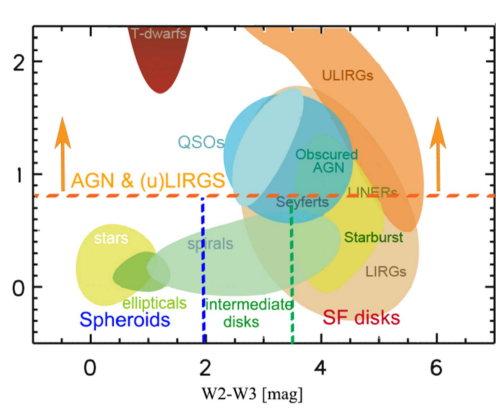

Assigning classifications as defined in the color-color diagram by Jarrett et al. (2017) in Fig. 11 (b):

- AGNs & (u)LIRGS are found at $W1-W2>0.8$ mag
- Meanwhile the region $W1-W2<0.8$ is divided into three parts:
- Spheroids are found at $W2-W3<2$ mag
- Intermediate disks are found at $2<W2-W3<3.5$ mag
- SF disks are found at $W2-W3>3.5$ mag

In [14]:
#defining the colors
#W2-W3
results2['cc_x']=results2['w2mpro']-results2['w3mpro']
#W1-W2
results2['cc_y']=results2['w1mpro']-results2['w2mpro']

In [15]:
#create a function that assigns the WISE classification
#according to the x- and y- values on the color-color diagram
def wise_class(x,y):
    if y>0.8:
        cls = 'AGN & (u)LIRGS'
    elif x<2:
        cls = 'Spheroids'
    elif x>2 and x<3.5:
        cls='Intermediate disks'
    else:
        cls='SF disks'
    return cls

def wise_col(x,y):
    if y>0.8:
        color='orange'
    elif x<2:
        color='blue'
    elif x>2 and x<3.5:
        color='green'
    else:
        color='red'
    return color

In [16]:
results2['wise_class'] = results2.apply(lambda x: wise_class(x['cc_x'], x['cc_y']), axis=1)
results2['wise_color'] = results2.apply(lambda x: wise_col(x['cc_x'], x['cc_y']), axis=1)

In [17]:
results2

,sdss_ra,sdss_dec,wise_ra,wise_dec,r,w1,oiii_5007_flux,h_alpha_flux,h_beta_flux,nii_6584_flux,...,w1mpro,w2mpro,w3mpro,wise_cntr,sdss_objid,specobjid,cc_x,cc_y,wise_class,wise_color
0,146.628757,34.916838,146.628833,34.917140,16.37781,11.940,173.52530,4204.3220,1019.06200,3133.5350,...,11.940,11.605,7.006,1461134801241017517,1237661382235783225,1794693572675528704,4.599,0.335,SF disks,red
1,153.202376,43.145539,153.202393,43.145573,15.16157,10.633,141.22830,276.3123,88.41828,321.8531,...,10.633,10.678,9.623,1537142401241035207,1237660635994259485,1371479997524502528,1.055,-0.045,Spheroids,blue
2,143.176249,2.533577,143.176263,2.533641,17.05236,12.691,47.88549,1360.4180,382.54200,860.1495,...,12.691,12.462,8.452,1436103001241006144,1237654599949746289,640704979820111872,4.010,0.229,SF disks,red
3,180.329534,56.570169,180.329622,56.570240,16.45819,11.699,71.68056,116.4147,22.47028,153.5428,...,11.699,11.701,9.386,1813156001241039765,1237657610729357488,1479510319209408512,2.315,-0.002,Intermediate disks,green
4,174.728890,3.580878,174.728897,3.580922,16.37154,11.642,107.56460,3212.7550,702.71580,1216.7800,...,11.642,11.592,7.988,1754103001241033794,1237654031403712563,577752436958062592,3.604,0.050,SF disks,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,242.398705,8.956686,242.398840,8.956539,16.48749,11.549,80.75883,138.7333,28.08064,135.7143,...,11.549,11.624,9.817,2420109001241019730,1237662637987069988,2844058975685601280,1.807,-0.075,Spheroids,blue
957,126.575168,27.840223,126.575298,27.840127,15.66866,10.936,201.57480,662.5453,206.01010,450.8914,...,10.936,10.969,9.759,1267127201241035915,1237660764836135043,1426645798166226944,1.210,-0.033,Spheroids,blue
958,38.197620,0.678089,38.197665,0.678057,17.10240,13.864,5639.00600,4075.1110,1402.15100,237.3731,...,13.864,13.760,10.516,378100001241034281,1237657587096813624,458390276445071360,3.244,0.104,Intermediate disks,green
959,196.914220,6.335939,196.914298,6.335928,16.02470,11.220,101.11320,750.1812,178.31770,444.3834,...,11.220,11.143,7.850,1974106001241023443,1237661974404923406,2021061876653254656,3.293,0.077,Intermediate disks,green


Text(4, 0.55, 'SF disks')

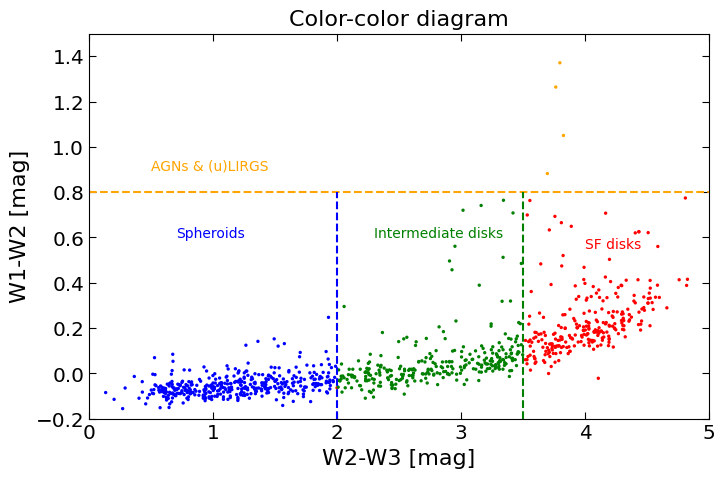

In [18]:
#plot BPT diagram
fig=plt.figure(figsize=(8, 5))
plt.tick_params(axis="both", direction='in', length=5, bottom=1, top=1, left=1, right=1, which='both')

plt.xlabel('W2-W3 [mag]', fontsize = 16)
plt.ylabel('W1-W2 [mag]', fontsize = 16)
plt.title('Color-color diagram', fontsize = 16)

plt.scatter(results2['cc_x'], results2['cc_y'], s=2, color=results2['wise_color'])

#set plot area
plt.xlim(0,5)
ymin=-0.2
ymax=1.5
plt.ylim(ymin,ymax)

#plot classification sections
agn_ulirgs_line=(0.8-ymin)/(ymax-ymin)
plt.axhline(y=0.8, linestyle='--', color='orange')
plt.axvline(x=2, ymax=agn_ulirgs_line, linestyle='--', color='blue')
plt.axvline(x=3.5, ymax=agn_ulirgs_line, linestyle='--', color='green')

#label populations
plt.text(0.5,0.9,'AGNs & (u)LIRGS', color='orange')
plt.text(0.7,0.6,'Spheroids', color='blue')
plt.text(2.3,0.6,'Intermediate disks', color='green')
plt.text(4, 0.55,'SF disks', color='red')

To compare the two classification methods, find the quantities of AGNs and SF (starburst) galaxies in each classification scheme, using the most recent (Kaufmann, 2003) classification method from the BPT diagram.

In [19]:
#comparing the number of AGNs
bpt_agn=results.loc[results['kaufmann_class']=='AGN']
print('Number of AGNs according to BPT classification = ', len(bpt_agn))
wise_agn=results2.loc[results2['wise_class']=='AGN & (u)LIRGS']
print('Number of AGNs (& (u)LIRGS) according to WISE classification = ', len(wise_agn))

#comparing the number of SF galaxies
bpt_sb=results.loc[results['kaufmann_class']=='starburst']
print('\nNumber of starburst (SF) galaxies according to BPT classification = ', len(bpt_sb))
wise_sb=results2.loc[results2['wise_class']=='SF disks']
print('Number of SF galaxies according to WISE classification = ', len(wise_sb))

Number of AGNs according to BPT classification =  729
Number of AGNs (& (u)LIRGS) according to WISE classification =  4

Number of starburst (SF) galaxies according to BPT classification =  245
Number of SF galaxies according to WISE classification =  262


It is evident from the plots and statistics above that the WISE database contains measurements for only very few AGNs when compared to the results from SDSS as classified through the BPT. On the other hand, the number of SF galaxies found by WISE is only slightly more than the number of SF galaxies in the SDSS database within our criteria.

## Q.5
**Locate one random object on the WISE color-color plot having $W1-W2>=0.8$ (Assef et al., 2013) and address the following:**
- **Where is the object located in this plot? Mark it clearly on the graph.**
- **Does it agree with the optical classification from BPT diagram?**
- **Draw some conclusions about the type of AGN using the WISE color-color plot.**

Using a random number generator (`np.random`), we choose the 3rd result classified as AGN or (u)LIRG by the WISE classification.

In [20]:
#rand=np.random.randint(0, len(wise_agn))
rand = 3
#print(rand)

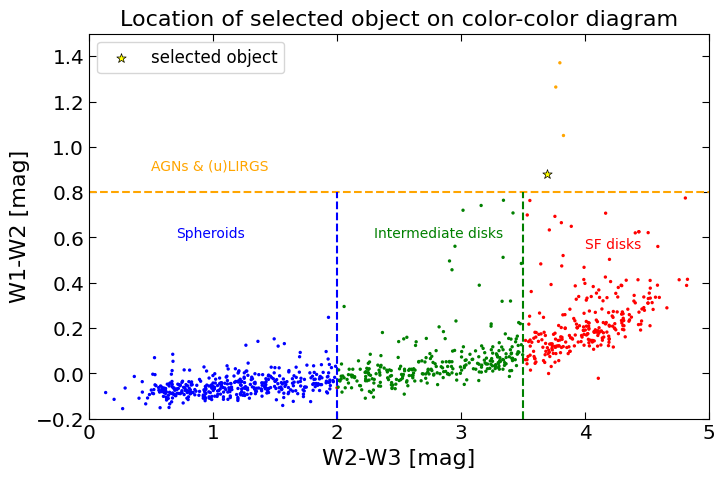

In [21]:
#plot BPT diagram
fig=plt.figure(figsize=(8, 5))
plt.tick_params(axis="both", direction='in', length=5, bottom=1, top=1, left=1, right=1, which='both')

plt.xlabel('W2-W3 [mag]', fontsize = 16)
plt.ylabel('W1-W2 [mag]', fontsize = 16)
plt.title('Location of selected object on color-color diagram', fontsize = 16)

plt.scatter(results2['cc_x'], results2['cc_y'], s=2, color=results2['wise_color'])

#plotting location of randomly chosen AGN
plt.scatter(wise_agn.iloc[3]['cc_x'], wise_agn.iloc[3]['cc_y'], marker='*', color='yellow', edgecolor='black', linewidth=0.5, s=50, label='selected object')

#set plot area
plt.xlim(0,5)
ymin=-0.2
ymax=1.5
plt.ylim(ymin,ymax)

#plot classification sections
agn_ulirgs_line=(0.8-ymin)/(ymax-ymin)
plt.axhline(y=0.8, linestyle='--', color='orange')
plt.axvline(x=2, ymax=agn_ulirgs_line, linestyle='--', color='blue')
plt.axvline(x=3.5, ymax=agn_ulirgs_line, linestyle='--', color='green')

#label populations
plt.text(0.5,0.9,'AGNs & (u)LIRGS', color='orange')
plt.text(0.7,0.6,'Spheroids', color='blue')
plt.text(2.3,0.6,'Intermediate disks', color='green')
plt.text(4, 0.55,'SF disks', color='red')

plt.legend(fontsize=12)

In [22]:
find=np.where(results['specobjid']==wise_agn.iloc[rand]['specobjid'])[0][0]
print('The random object is found in location ', find, ' in the first SDSS query results, and is classified as: ', results.iloc[find]['kaufmann_class'], ' according to Kaufmann classification line and ', results.iloc[find]['kewley_class'], ' according to the Kewley classification line.')

The random object is found in location  643  in the first SDSS query results, and is classified as:  AGN  according to Kaufmann classification line and  starburst  according to the Kewley classification line.


Text(-1.5, -1, 'Starburst')

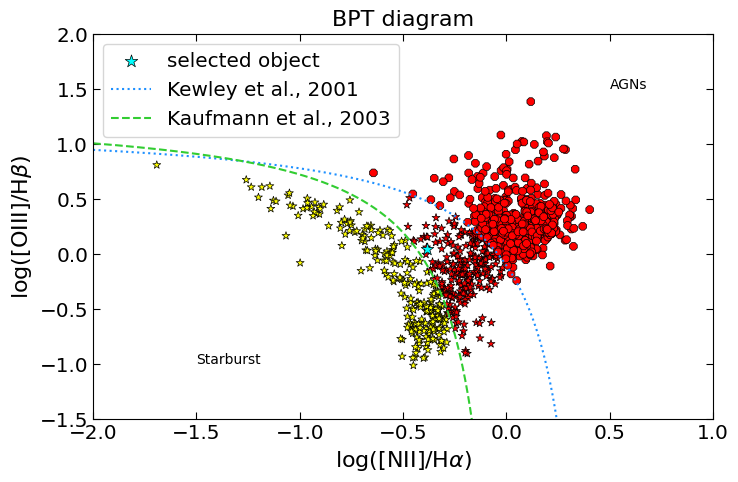

In [23]:
#plot BPT diagram
fig=plt.figure(figsize=(8, 5))
plt.tick_params(axis="both", direction='in', length=5, bottom=1, top=1, left=1, right=1, which='both')

for marker, d in results.groupby('shape'):
    plt.scatter(x=d['bpt_x'], y=d['bpt_y'], c=d['color'], marker=marker, edgecolors= "black", linewidth=0.5)

plt.scatter(results.iloc[find]['bpt_x'], results.iloc[find]['bpt_y'], color='aqua', s=90, marker='*', edgecolors= "black", linewidth=0.5, label='selected object')

plt.xlabel(r'log([NII]/H$\alpha$)', fontsize = 16)
plt.ylabel(r'log([OIII]/H$\beta$)', fontsize = 16)
plt.title('BPT diagram', fontsize = 16)
plt.xlim(-2,1)
plt.ylim(-1.5,2)

#plot kewley line
plt.plot(kew_x,kew_y, color = 'dodgerblue', ls='dotted', label = 'Kewley et al., 2001')
#plot kaufmann line
plt.plot(kauf_x, kauf_y, color = 'limegreen', ls='--', label = 'Kaufmann et al., 2003')
plt.legend()

#label populations
plt.text(0.5,1.5,'AGNs')
plt.text(-1.5,-1,'Starburst')

The latest (Kaufmann) methodology for optical (BPT) classificaiton agrees with the WISE classificaiton since they both class our random object as an AGN. It is worth noting, however that using the old (Kewley) classification scheme would lead to disagreement between the two methodologies. Nonetheless, the results obtained strongly suggest that the selected object is an AGN.

## References

[1] [FWHM to sigma conversion](https://brainder.org/2011/08/20/gaussian-kernels-convert-fwhm-to-sigma/)

[2] [Kewley, L. J., Dopita, M. A., Sutherland, R. S., Heisler, C. A., and Trevena, J., “Theoretical Modeling of Starburst Galaxies”, _The Astrophysical Journal_, vol. 556, no. 1, IOP, pp. 121–140, 2001. doi:10.1086/321545.](https://ui.adsabs.harvard.edu/abs/2001ApJ...556..121K/abstract)

[3] [Kaufmann, G., Heckman, T. M., Tremonti, C., Brinchmann, J., Charlot, S., White, S. D. M., "The host galaxies of active galactic nuclei", _Monthly Notices of the Royal Astronomical Society_, vol. 346, no. 4, pp. 1055-1077, 2003.](https://adsabs.harvard.edu/full/2003MNRAS.346.1055K)

[4] [SDSS Sky Server SQL Search Tool](https://skyserver.sdss.org/dr18/SearchTools/sql)

[5] [Wright E., et al., "The Wide-field Infrared Survey Explorer (WISE) Mission Description and Initial On-orbit Performance", _The Astronomical Journal_, vol. 140, no. 6, pp. 1868-1881, 2010.](https://ui.adsabs.harvard.edu/abs/2010AJ....140.1868W/abstract)

[6] [Jarrett, T. H., "Galaxy and Mass Assembly (GAMA): Exploring the _WISE_ Web in G12", _The Astrophysical Journal_, vol. 836, no. 2, 2017.](https://iopscience.iop.org/article/10.3847/1538-4357/836/2/182)